In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# Eupopean call option

 * $S$: the current stock price (at time 0);
 * $r$: one plus riskless interest rate
 * $p$: the probability that the stock price increases in one period
 
 The model is 
 $$S_{t+1} = \left\{
 \begin{align} 
 &uS_t, ~~with~~probability~~p\\
 &dS_t, ~~with~~probability~~1-p\\
 \end{align}\right.$$
 where $u>r>d$ and $u,d,p$ and $r$ are constant throughout time
<br>
<br>
 * $C_u = max(0, uS-K)$ is the call option price if $S \rightarrow uS$
 * $C_d = max(0, dS-K)$ is the call option price if $S \rightarrow dS$
 <br>
 <br>
 Suppose now we have a portfolio containing $\Delta$ shares of stock and $B$ dolloars of riskless bonds. At the end f the period, the value of the portfolio becomes 
 $$\left\{
 \begin{align} 
 &uS\Delta + rB, ~~with~~probability~~p\\
 &dS\Delta + rB, ~~with~~probability~~1-p\\
 \end{align}\right.$$
 Now we let 
 $$\bigg\{
 \begin{align} 
 &uS\Delta + rB = C_u\\
 &dS\Delta + rB = C_d\\
 \end{align}$$
 This equations yields
 $$\Delta = \frac{C_u - C_d}{(u-d)S},~~~~B = \frac{uC_d - dC_u}{(u-d)r}.$$
 
<br>
Assuming no arbitrage opportunities, it must be true that 
\begin{align}
C &= S\Delta+B\\
& = \frac{C_u - C_d}{u-d} + \frac{uC_d - dC_u}{(u-d)r}\\
&=\frac{1}{r}\left[\frac{r-d}{u-d}C_u = \frac{u-r}{u-d}C_d  \right]
\end{align}

<br>
Defining $q:=\frac{r-d}{u-d}$ yields $C=r^{-1}\left[qC_u+(1-q)C_d\right]$.

<br>
For the $T$ period option, we can first recursively generate the stock prices and then recursively calculate the option prices.

## T-period binomial pricing tree

Use 2D array to stroe the value

In [2]:
def arrayD2Tree(S=100, u=1.2, r=1.1, d=0.9, T=3, K=100):
    lattice = np.zeros((T+1, 2**T))
    lattice[0][0] = S
    
    # calculate the expired stock price
    for i in range(0, T):
        for j in range(2**i):
            lattice[i+1][2*j] = lattice[i][j] * d
            lattice[i+1][2*j+1] = lattice[i][j] * u

    q = (r - d) / (u - d) # the Q measure
    
    # calculate the payoff at leaves
    for j in range(2**T):
        lattice[T][j] = max([0, lattice[T][j] - K])
        
    # back from the leaves
    for i in range(T-1, 0, -1):
        for j in range(2**i):
            lattice[i][j] = ((1 - q) * lattice[i+1][2*j] + q * lattice[i+1, 2*j+1]) / r
    lattice[0][0] = ((1 - q) * lattice[1][0] + q * lattice[1, 1]) / r

    return lattice[0][0]

arrayD2Tree()

26.090102123159994

## Improved T-period binomial pricing tree

Use 1D array to save more space

In [3]:
def arrayD1Tree(S=100, u=1.2, r=1.1, d=0.9, T=3, K=100):
    lattice = np.zeros(2 ** (T + 1) - 1)
    lattice[0] = S
    
    # calculate the expired stock price
    t = 1
    while t <= 2 ** (T - 1):
        for i in range(t-1, 2*t-1):
            lattice[2*i+1] = lattice[i] * d
            lattice[2*i+2] = lattice[i] * u
        t *= 2
        
    #for i in range(T+1):
    #    print(lattice[2**i-1: 2**(i+1)-1])

    q = (r - d) / (u - d) # the Q measure
    
    # calculate the payoff at leaves
    for i in range(t-1, 2*t-1):
        lattice[i] = max([0, lattice[i] - K])
        
    # back from the leaves
    t //= 2
    while t > 0:
        for i in range(t-1, 2*t-1):
            lattice[i] = ((1 - q) * lattice[2*i+1] + q * lattice[2*i+2]) / r
        t //= 2
        
    #for i in range(T+1):
    #    print(lattice[2**i-1: 2**(i+1)-1])

    return lattice[0]

arrayD1Tree()

26.090102123159994

## Simpler formula by binomial theorem
Among the n periods, suppose the stock experienced $j$ up moves and $n-j$ down moves, the stock price at expiration is $S_T := u^jd^{T-j}S$, and the call value at expiration is $max(0, u^jd^{n-j}S-K)$. Using Binomial theorem we can further write<br>

$$C=r^{-T}\sum_{j=0}^T\left[\binom{T}{j}q^j(1-q)^{T-j}max\left(0, u^jd^{T-j}S-K \right) \right]$$

Let $a := \lceil \log(K/Sd^T)/\log(u/d) \rceil$ be the first nonnegative integer such that $u^jd^{T-j}S>K$. We can further write
<br>

\begin{align}
C&=r^{-T}\sum_{j=a}^T\left[\binom{T}{j}q^j(1-q)^{T-j}\left(u^jd^{T-j}S-K \right) \right]\\
& = S\left[\sum_{j=a}^T\binom{T}{j}q^j(1-q)^{T-j}\frac{u^jd^{T-j}}{r^T} \right] - Kr^{-n}\left[\sum_{j=a}^T\binom{T}{j}q^j(1-q)^{T-j} \right]\\
& = S\Phi[a;T,q']-Kr^{-T}\Phi[a;T,q]
\end{align}
where $$q'=\frac{u}{r}q$$ and $$\Phi[a;T,q]:=\sum_{j=a}^T\binom{T}{j}q^j(1-q)^{T-j}$$

In [4]:
def binOption(S=100, u=1.2, r=1.1, d=0.9, T=3, K=100):
    a = np.floor(np.log(K / S / d ** T) / np.log(u / d))  # here we use floor because we will use 1-cdf below
    q = (r - d) / (u - d)
    phi = 1 - scipy.stats.binom.cdf(a, T, q)
    q_1 = (u / r) * q   # correspoinding q'
    phi_1 = 1 - scipy.stats.binom.cdf(a, T, q_1, loc=0)  # corresponding phi'
    return S * phi_1 - K / r ** T * phi
binOption()

26.090102123159994

## Limiting distribution of $\log{(S_T/S)}$

Now we assume that the stock price changes $n$ times (instead of $T$ times) in the $T$ periods, and denote the corresponding interest rate (plus one) as $\widehat{r}_n$ so that 
<br><br> 
$$\widehat{r}_n^n=r^T.$$
<br>
We would like to consider what will happen if $n\rightarrow \infty$. It turns out to be Black-Scoles formula.
Now $q,d,u,r$ are not constants any more, depending on $n$.

Define our $q$ measure as $$q_n:=\frac{\widehat{r}_n - d_n}{u_n-d_n}$$

Since $S_T=u_n^jd_n^{n-j}S$, we can write $$\log{(S_T/S)} = j\log{u_n} + (n-j)\log{d_n}.$$

Clearly $j\sim Bin(n,q_n)$ so that
\begin{align}
\mathbb{E}^Q[\log{(S_T/S)}] & = \left[q_n\log{(u_n/d_n)}+\log{d_n} \right]n &=: \widehat{\mu}_nn\\
\mathbb{V}^Q[\log{(S_T/S)}] & = q_n(1-q_n)\left[\log{(u_n/d_n)} \right]^2n &=: \widehat{\sigma}^2_nn
\end{align}
where we define
\begin{align}
\widehat{\mu}_n & := q_n\log{(u_n/d_n)}+\log{d_n}\\
\widehat{\sigma}^2_n & :=q_n(1-q_n)\left[\log{(u_n/d_n)} \right]^2
\end{align}

We can view $\log{(S_T/S)}$ as the sum of $n$ independent random variables, each of which can take the value $\log{u_n}$ with probability $q_n$ and $\log{d_n}$ with probability $1-q_n$, with mean $\widehat{\mu}_n$ and variance $\widehat{\sigma}^2_n$.

Different choices of $u_n, d_n, q_n$ can leads to different limitting distributions. We consider the case where

$$u_n=e^{\sigma\sqrt{T/n}},~~~~~d_n=e^{-\sigma\sqrt{T/n}}$$
where $\sigma$ are given.

To use central limited theorem, we need $\widehat{\mu}_nn<\infty$ and $\widehat{\sigma}^2_nn<\infty$. In fact, one can show that $\widehat{\mu}_nn \rightarrow (\log{r}-\frac{1}{2}\sigma^2)T$ and $\widehat{\sigma}^2_nn \rightarrow \sigma^2 T$

Then by Lyapunov Central Limited Theorem, 
$$P\left(\frac{\log{(S_T/S)} - \widehat{\mu}_nn}{\widehat{\sigma}_n\sqrt{n}}\leq z \right) \rightarrow N(z)$$
where $N(z)$ is the CDF of the standard normal distribution.

muHat*n= -1.21404217009 and (log r-0.5sigma^2)T= -1.21406946059
sigmaHat^2*n= 2.99985261016 and sigma^2*T= 3


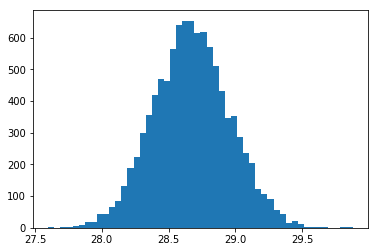

In [5]:
def testNormal(S=100, T=3, r=1.1, sigma=1, n=10000):
    u = np.exp(sigma * np.sqrt(T / n))
    d = 1 / u
    rHat = (r ** T) ** (1 / n)
    q = (rHat - d) / (u - d)
    muHat = q * np.log(u / d) + np.log(d)
    sigmaHat = np.sqrt(q * (1 - q)) * np.log(u / d)
    log_ST_S = np.random.binomial(n, q, 10000)  # generate 10000 samples
    print("muHat*n=", muHat * n, "and (log r-0.5sigma^2)T=", (np.log(r) - 0.5 * sigma**2) * T)
    print("sigmaHat^2*n=", sigmaHat ** 2 * n, "and sigma^2*T=", sigma ** 2 * T)
    return (log_ST_S - muHat * n) / sigmaHat / n

plt.hist(testNormal(), bins=50)
plt.show()

## Block-Scholes formula

We can rewrite our call option price as $$C=S\Phi[a_n;n,q_n']-Kr^{-n}\Phi[a_n;n,q_n]$$
where 
$$a:= \lceil \log(K/Sd_n^n)/\log(u_n/d_n) \rceil,~~~~~q_n' :=\frac{u_n}{r_n}q_n, ~~~~~\Phi[a_n;n,q_n] :=\sum_{j=a_n}^n\binom{n}{j}q_n^j(1-q_n)^{n-j}$$

We can write $$1-\Phi[a_n;n,q_n]=P(j\leq a_n-1)=P\left(\frac{j-nq_n}{\sqrt{nq_n(1-q_n)}} \leq \frac{a_n-1-nq_n}{\sqrt{nq_n(1-q_n)}} \right)$$

First we can calculate that $$\frac{j-nq_n}{\sqrt{nq_n(1-q_n)}}=\frac{\log{(S_T/S)} - \widehat{\mu}_nn}{\widehat{\sigma}_n\sqrt{n}}$$

Then note that we can write $a_n$ as $$a_n=\log(K/Sd_n^n)/\log(u_n/d_n) - \varepsilon~~~~~~~~~~~~where~~ \varepsilon \in (0,1)$$
Thus
$$\frac{a_n-1-nq_n}{\sqrt{nq_n(1-q_n)}} = \frac{\log{(K/S)}- \log{(u_n/d_n)} - \widehat{\mu}_nn - \varepsilon\log{(u_n/d_n)}}{\widehat{\sigma}_n\sqrt{n}} \rightarrow \frac{\log{(K/S)} - (\log{r}-\frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}$$

Hence we have 
$$1-\Phi[a_n;n,q_n] \rightarrow N\left(\frac{\log{(K/S)} - (\log{r}-\frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}} \right)$$
The proof for $\Phi[a_n;n,q_n']$ is similar.

Finally we get our Black-Scholes formula:
$$C=SN(x)-Kr^{-T}N(x-\sigma\sqrt{T}) ~~~~~~ where~~x = \frac{\log{(S/K)}+T\log{r}}{\sigma\sqrt{T}}+\frac{1}{2}\sigma\sqrt{T}$$

In [6]:
def BS(S=100, sigma=1, r=1.1, T=3, K=100):
    x = (np.log(S / K) + T * np.log(r)) / sigma / np.sqrt(T) + 0.5 * sigma * np.sqrt(T)
    return S * scipy.stats.norm.cdf(x) - K / r ** T * scipy.stats.norm.cdf(x - sigma * np.sqrt(T))
BS()

66.71851490696136

The binomial tree price will converge to BS price:

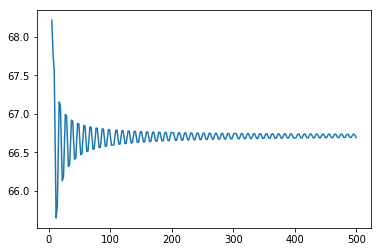

In [7]:
def binOption2(S=100, sigma=1, r=1.1, n=10000, T=3, K=100):
    u = np.exp(sigma * np.sqrt(T / n))
    d = 1 / u
    rHat = (r ** T) ** (1 / n)
    a = np.floor(np.log(K / S / d ** n) / np.log(u / d))  # here we use floor because we will use 1-cdf below
    q = (rHat - d) / (u - d)
    phi = 1 - scipy.stats.binom.cdf(a, n, q)
    q_1 = (u / rHat) * q   # correspoinding q'
    phi_1 = 1 - scipy.stats.binom.cdf(a, n, q_1)  # corresponding phi'
    return S * phi_1 - K / r ** T * phi

n = np.linspace(5, 500, 200, dtype=int)
prices = binOption2(n=n)
plt.plot(n, prices)
plt.show()

## Implied volatility

In real world, $S, K, r, T$ and $C$ are given. We use BS model to find $\sigma$ because $C$ is an 1-1 increasing function of $\sigma$:

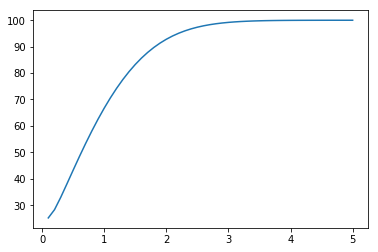

In [8]:
sigmas = np.linspace(0.1, 5, 50)
prices = BS(sigma=sigmas)
plt.plot(sigmas, prices)
plt.show()

We can use Newton-Raphson method to calculate implied volatility. Recall the Newton-Raphson method:

$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$

Here $x$ is $\sigma$ and $f(x)$ is the difference of real price and the price given by BS model.

The partial derivative is
$$\frac{\partial C}{\partial \sigma} = SN'(x)\frac{\partial x}{\partial \sigma} - Kr^{-T}N'(x-\sigma \sqrt{T})\left(\frac{\partial x}{\partial \sigma}-\sqrt{T} \right)$$

where $N'(x)$ is the density of standard normal distribution at $x$ and 
$$\frac{\partial x}{\partial \sigma} = -\frac{\log{(S/K)}+T\log{r}}{\sigma^2 \sqrt{T}}+\frac{1}{2}\sqrt{T}$$

In [9]:
def impliedVolatility(S=100, K=100, r=1.1, T=3, C=50):
    sigma = 1
    BSprice = BS(S=S, sigma=sigma, r=r, T=T, K=K)
    diff = BSprice - C
    while np.abs(diff) > 1e-6:
        x = (np.log(S / K) + T * np.log(r)) / sigma / np.sqrt(T)
        partialX = -(np.log(S / K) + T * np.log(r)) / sigma ** 2 / np.sqrt(T) + 0.5 * np.sqrt(T)
        derivative = S * scipy.stats.norm.pdf(x) * partialX - \
                     K / r ** T * scipy.stats.norm.pdf(x-sigma*np.sqrt(T)) * (partialX - np.sqrt(T))
        sigma -= 0.05 * diff / derivative
        BSprice = BS(S=S, sigma=sigma, r=r, T=T, K=K)
        diff = BSprice - C
    return sigma
impliedVolatility()

0.63289352927199527